dataset: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv("GlobalTemperatures.csv", parse_dates=['dt'])
df = df[['dt', 'LandAndOceanAverageTemperature']].dropna()
df = df.set_index('dt')

In [3]:
df.head()

,LandAndOceanAverageTemperature
dt,
1850-01-01,12.833
1850-02-01,13.588
1850-03-01,14.043
1850-04-01,14.667
1850-05-01,15.507


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1992 entries, 1850-01-01 to 2015-12-01
Data columns (total 1 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LandAndOceanAverageTemperature  1992 non-null   float64
dtypes: float64(1)
memory usage: 31.1 KB


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(df.values)

In [11]:
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i+time_step, 0])
    return np.array(X), np.array(y)

In [12]:
time_step = 12 
X, y = create_dataset(data_scaled, time_step)

In [13]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [14]:
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(time_step, 1)),
    Dense(1)
])

In [17]:
model.compile(optimizer='adam', loss='mse')

In [18]:
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0757
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0270
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011  
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.1301e-04
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5794e-04
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1011e-04


In [19]:
y_pred = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [20]:
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [26]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mse

0.02589014927403457

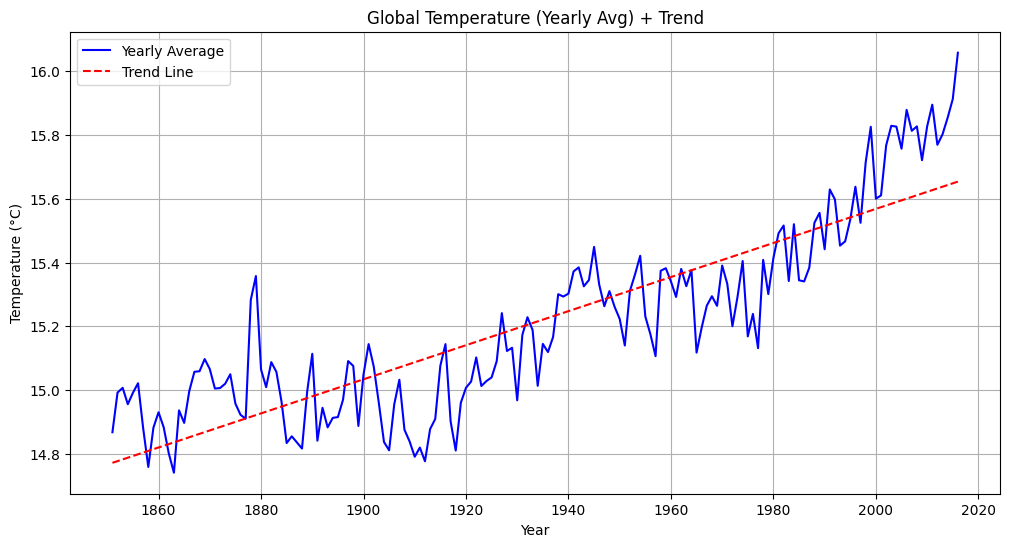

In [27]:
df_yearly = df.resample("YE").mean()

plt.figure(figsize=(12,6))
plt.plot(df_yearly.index, df_yearly['LandAndOceanAverageTemperature'], label="Yearly Average", color="blue")

z = np.polyfit(range(len(df_yearly)), df_yearly['LandAndOceanAverageTemperature'], 1)
p = np.poly1d(z)

plt.plot(df_yearly.index, p(range(len(df_yearly))), "r--", label="Trend Line")

plt.title("Global Temperature (Yearly Avg) + Trend")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()